In [1]:
import pandas as pd
import numpy as np
from scipy import signal, stats
import matplotlib.pyplot as plt
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns

This script is the interactive/dev version to turn the bci states into a csv comprable to the csvs I get from prolifc in order to compare their behavior.

The basic plan is to create and index to get a timestep of 50ms, loop through all of my_states, pull values for each variable of interest into a csv.

In [7]:
## sample time step
# for our normal analyses we used 50ms to match the behavioral data
# for encoding models we will increase this to 10ms

sample_step = .01

In [4]:
## prep paths

subject = 'LL13'
orig_data_fi = '/home/brooke/knight_server/remote/ecog/DATA_FOLDER/Loma_Linda/LL13/Datafiles/BCI/DAY1/PacmanTask/ECOG001/ECOGS001R01.dat'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}/ieeg"

In [5]:
with b2k.BCI2kReader(orig_data_fi) as data: #opens a stream to the dat file
    my_signals = data.signals
    my_states = data.states
    my_params = data.parameters

In [6]:
col_names =  ['Subject',
              'Trial',
               'Time', 
               'GhostLocation',
               'UserLocation',
               'Direction',
               'Biscuit1',
               'Biscuit2',
               'Biscuit3',
               'Biscuit4',
               'Biscuit5',
               'Attack',
               'Chase',
               'Eaten',
               'Score',
               'Lives',
               'TrialType']

cleaned_game_data = pd.DataFrame(columns = col_names)

In [9]:
samples_per_500 = my_params['SamplingRate'] * sample_step
task_length = len(my_states['Trial_on_off'][0])
flips_per_task = int(task_length / samples_per_500)



Okay, so every 50ms, corresponds to a csv with `nrows = 59019`, which is *much* larger than the size of the csvs from prolific data. However, the ITIs in the prolific data are not sampled at 50ms, and the task was run twice for this subject. So together, I think this makes sense 

In [10]:
for iter in range(flips_per_task):
    sample = int(range(task_length)[iter] * samples_per_500)
    cleaned_game_data.loc[iter] = [subject, my_states['Trial_on_off'][0][sample], sample,
              my_states['GhostLocation'][0][sample], my_states['UserLocation'][0][sample], my_states['Direction'][0][sample],  
              my_states['Biscuit1'][0][sample], my_states['Biscuit2'][0][sample], my_states['Biscuit3'][0][sample],
              my_states['Biscuit4'][0][sample], my_states['Biscuit5'][0][sample], my_states['Attack'][0][sample],
              my_states['Chase'][0][sample], my_states['Eaten'][0][sample], my_states['Score'][0][sample],
              my_states['Lives'][0][sample], my_states['TrialType'][0][sample]]


In [12]:
cleaned_game_data

,Subject,Trial,Time,GhostLocation,UserLocation,Direction,Biscuit1,Biscuit2,Biscuit3,Biscuit4,Biscuit5,Attack,Chase,Eaten,Score,Lives,TrialType
0,LL13,0,0,0,0,4,0,0,0,0,0,0,0,0,0,3,0
1,LL13,0,5,0,0,4,0,0,0,0,0,0,0,0,0,3,0
2,LL13,0,10,0,0,4,0,0,0,0,0,0,0,0,0,3,0
3,LL13,0,15,0,0,4,0,0,0,0,0,0,0,0,0,3,0
4,LL13,0,20,0,0,4,0,0,0,0,0,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175991,LL13,1,901073,48,134,2,1,1,1,0,0,0,0,3,940,1,3
175992,LL13,1,901079,48,134,2,1,1,1,0,0,0,0,3,940,1,3
175993,LL13,1,901084,48,134,2,1,1,1,0,0,0,0,3,940,1,3
175994,LL13,1,901089,48,134,2,1,1,1,0,0,0,0,3,940,1,3


In [13]:
# filter to beginning of trial
first_trial = cleaned_game_data.Trial.eq(1).idxmax() - 3 # start a couple of time points ahead of first trial
last_row = cleaned_game_data.shape[0]
cleaned_game_data = cleaned_game_data.loc[first_trial:last_row]

In [14]:
# get trial count
cleaned_game_data.reset_index(inplace=True, drop = True)
last_row = cleaned_game_data.shape[0]
end_index = False
begin_index = False
cleaned_game_data = cleaned_game_data.rename(columns={'Trial': 'Trial_on_off'})  
for idx in range(4, last_row):
    if cleaned_game_data.Trial_on_off[idx] == 0 and cleaned_game_data.Trial_on_off[idx - 1] == 1:
        begin_index = idx + 1
    if cleaned_game_data.Trial_on_off[idx] == 1 and cleaned_game_data.Trial_on_off[idx - 1] == 0:
        end_index = idx - 2
    if end_index is not False:
        bad_df = cleaned_game_data.index.isin(np.arange(begin_index, end_index))
        cleaned_game_data = cleaned_game_data[~bad_df]
        end_index = False
        begin_index = False
        

In [15]:
cleaned_game_data

,Subject,Trial_on_off,Time,GhostLocation,UserLocation,Direction,Biscuit1,Biscuit2,Biscuit3,Biscuit4,Biscuit5,Attack,Chase,Eaten,Score,Lives,TrialType
0,LL13,0,22092,0,0,4,0,0,0,0,0,0,0,0,0,3,0
1,LL13,0,22097,0,0,4,0,0,0,0,0,0,0,0,0,3,0
2,LL13,0,22103,0,0,4,0,0,0,0,0,0,0,0,0,3,0
3,LL13,1,22108,128,50,4,0,0,0,0,0,0,0,0,0,3,7
4,LL13,1,22113,128,50,4,0,0,0,0,0,0,0,0,0,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171676,LL13,1,901073,48,134,2,1,1,1,0,0,0,0,3,940,1,3
171677,LL13,1,901079,48,134,2,1,1,1,0,0,0,0,3,940,1,3
171678,LL13,1,901084,48,134,2,1,1,1,0,0,0,0,3,940,1,3
171679,LL13,1,901089,48,134,2,1,1,1,0,0,0,0,3,940,1,3


In [16]:
# so now there are three zeros separating every trial, so lets count the trials!
cleaned_game_data.reset_index(inplace=True, drop = True)
last_row = cleaned_game_data.shape[0]
trial_counter = 1
cleaned_game_data['Trial'] = 0
for idx in range(4, last_row):
    cleaned_game_data.loc[idx, 'Trial'] = trial_counter
    if cleaned_game_data.Trial_on_off[idx] == 0 and cleaned_game_data.Trial_on_off[idx - 1] == 1:
        trial_counter = trial_counter + 1

cleaned_game_data = cleaned_game_data[(cleaned_game_data['Trial'] != trial_counter)] # get rid of trailing zeros

In [29]:
## test 1
pd.set_option('display.max_rows', None)
cleaned_game_data[cleaned_game_data['Trial'].isin([3])]


,Subject,Trial_on_off,Time,GhostLocation,UserLocation,Direction,Biscuit1,Biscuit2,Biscuit3,Biscuit4,Biscuit5,Attack,Chase,Eaten,Score,Lives,TrialType,Trial
1152,LL13,0,31144,51,42,4,0,0,0,0,0,0,0,0,0,1,15,3
1153,LL13,0,31150,51,42,4,0,0,0,0,0,0,0,0,0,1,15,3
1154,LL13,1,31155,68,150,4,0,0,0,0,0,0,0,0,0,1,1,3
1155,LL13,1,31160,68,150,4,0,0,0,0,0,0,0,0,0,1,1,3
1156,LL13,1,31165,68,150,4,0,0,0,0,0,0,0,0,0,1,1,3
1157,LL13,1,31170,68,150,4,0,0,0,0,0,0,0,0,0,1,1,3
1158,LL13,1,31175,66,150,4,0,0,0,0,0,0,0,0,0,1,1,3
1159,LL13,1,31180,66,150,4,0,0,0,0,0,0,0,0,0,1,1,3
1160,LL13,1,31185,66,150,4,0,0,0,0,0,0,0,0,0,1,1,3
1161,LL13,1,31191,66,150,4,0,0,0,0,0,0,0,0,0,1,1,3


In [30]:
pd.reset_option('display.max_rows')

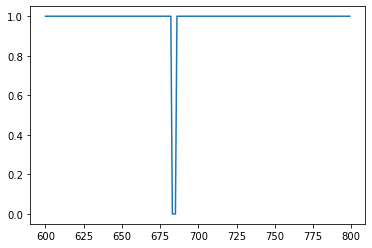

In [22]:
## test 2

plt.plot(range(600, 800), cleaned_game_data['Trial_on_off'][600:800])

In [23]:
## save it

cleaned_game_data.to_csv(f"{raw_data_dir}/../behave/{subject}_raw_encoding_behave.csv")